In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice', ylabel='Count'>

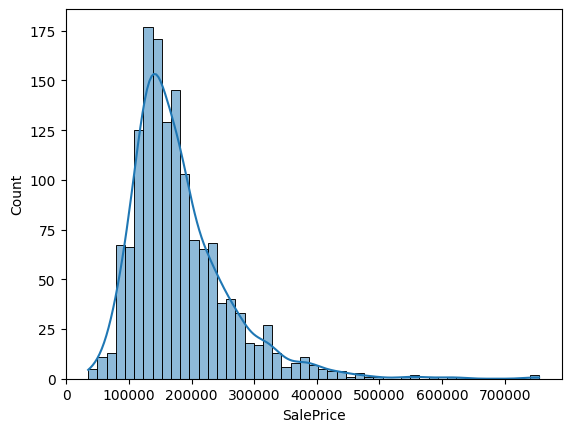

In [5]:
sns.histplot(train.SalePrice,kde=True)

<center>Relationship with numerical variables</center>

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

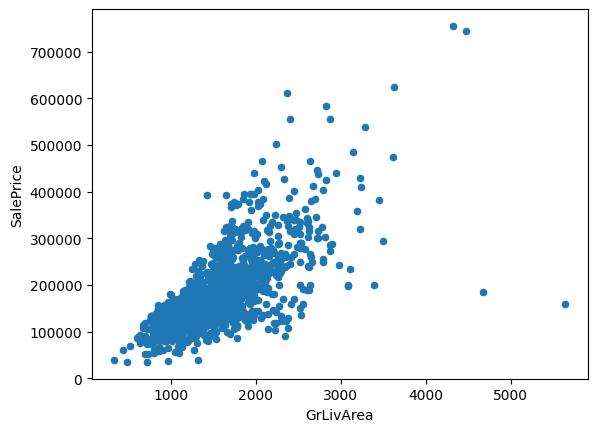

In [6]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice')

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

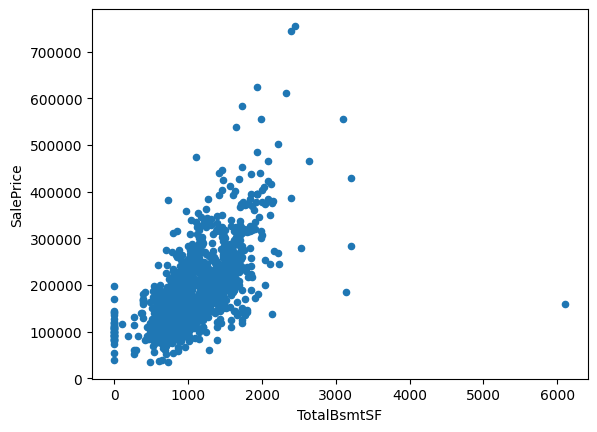

In [7]:
var='TotalBsmtSF'
data=pd.concat([train['SalePrice'],train[var]],axis=1)
data.plot.scatter(x=var,y='SalePrice')

<center>Relationship with categorical features</center>

In [8]:
list(set(train.dtypes.tolist()))

[dtype('int64'), dtype('float64'), dtype('O')]

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

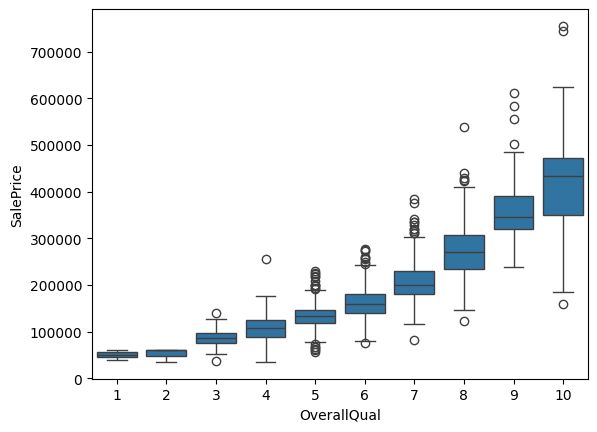

In [9]:
var='OverallQual'
data=pd.concat([train['SalePrice'],train[var]],axis=1)
sns.boxplot(data=data,x=var,y='SalePrice')

&emsp;&emsp;可以看出，随着OverallQual越大，SalePrice也会越高

<Axes: xlabel='YearBuilt', ylabel='SalePrice'>

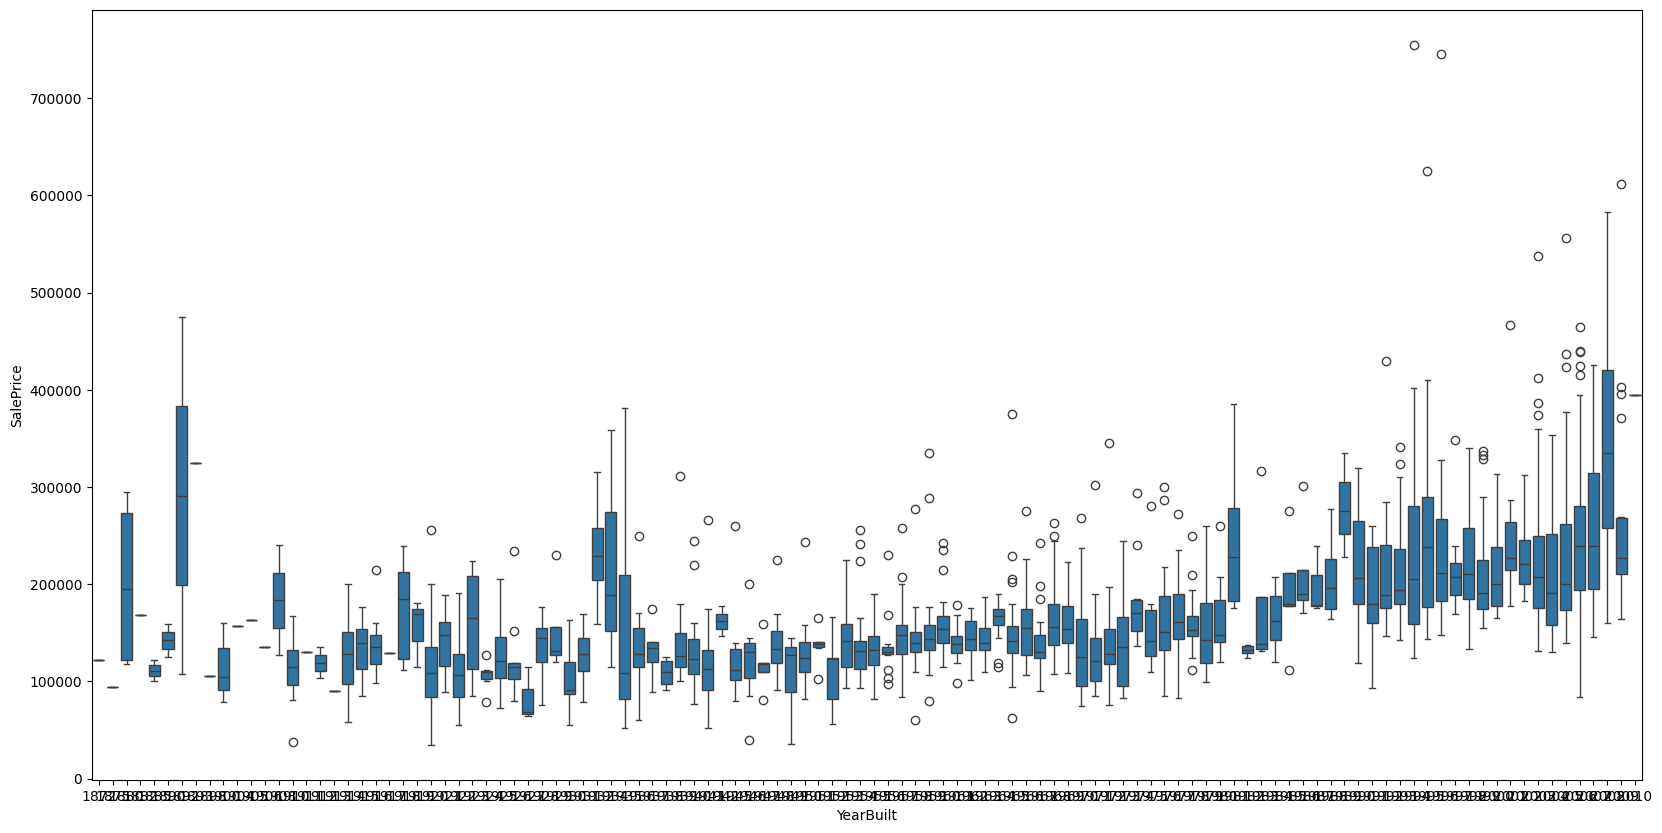

In [10]:
var='YearBuilt'
data=pd.concat([train['SalePrice'],train[var]],axis=1)
plt.figure(figsize=(20,10))
sns.boxplot(data=data,x='YearBuilt',y='SalePrice')

<center>系统性分析</center>

In [11]:
# 先选择类型为float64与int64的变量，进行热力图分析
train=train.select_dtypes(include=['int64','float64'])

In [12]:
set(train.dtypes)

{dtype('int64'), dtype('float64')}

<Axes: >

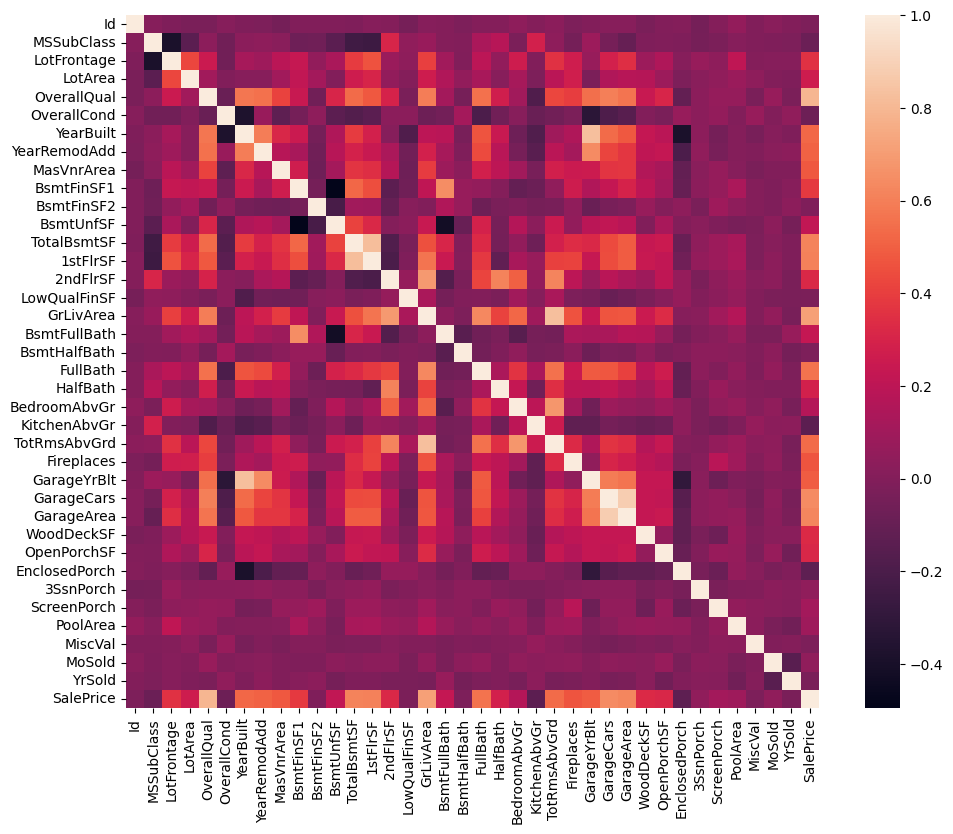

In [13]:
cor=train.corr()
plt.figure(figsize=(12,9))
sns.heatmap(cor,square=True)

&emsp;&emsp;我们可以从热力图看出，TotalBsmtSF与1stFlrSF呈现高度相关，我们认为两个变量存在多重共线性，与之类似的还有GarageX这三个变量

In [14]:
train[['OverallCond','SalePrice']].values.T

array([[     5,      8,      5, ...,      9,      6,      6],
       [208500, 181500, 223500, ..., 266500, 142125, 147500]], dtype=int64)

<Axes: >

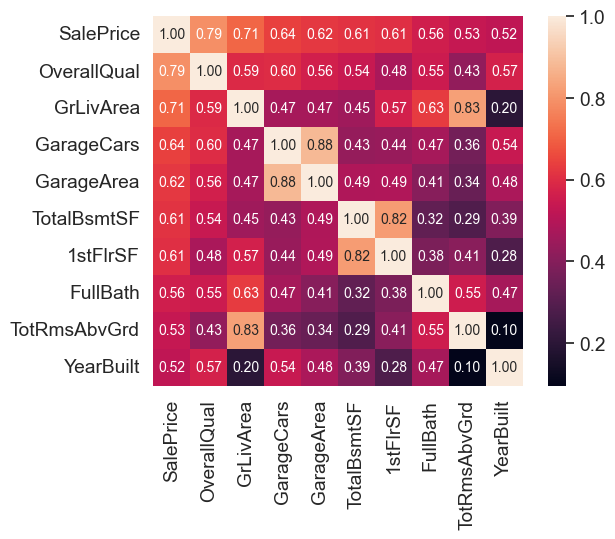

In [15]:
# SalePrice相关矩阵（缩放热图样式）
k = 10 #number of variables for heatmap
cols = cor.nlargest(k, 'SalePrice')['SalePrice'].index
# 在计算相关系数的时候，我们希望每一行代表一个变量，所以需要转置
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

In [16]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']

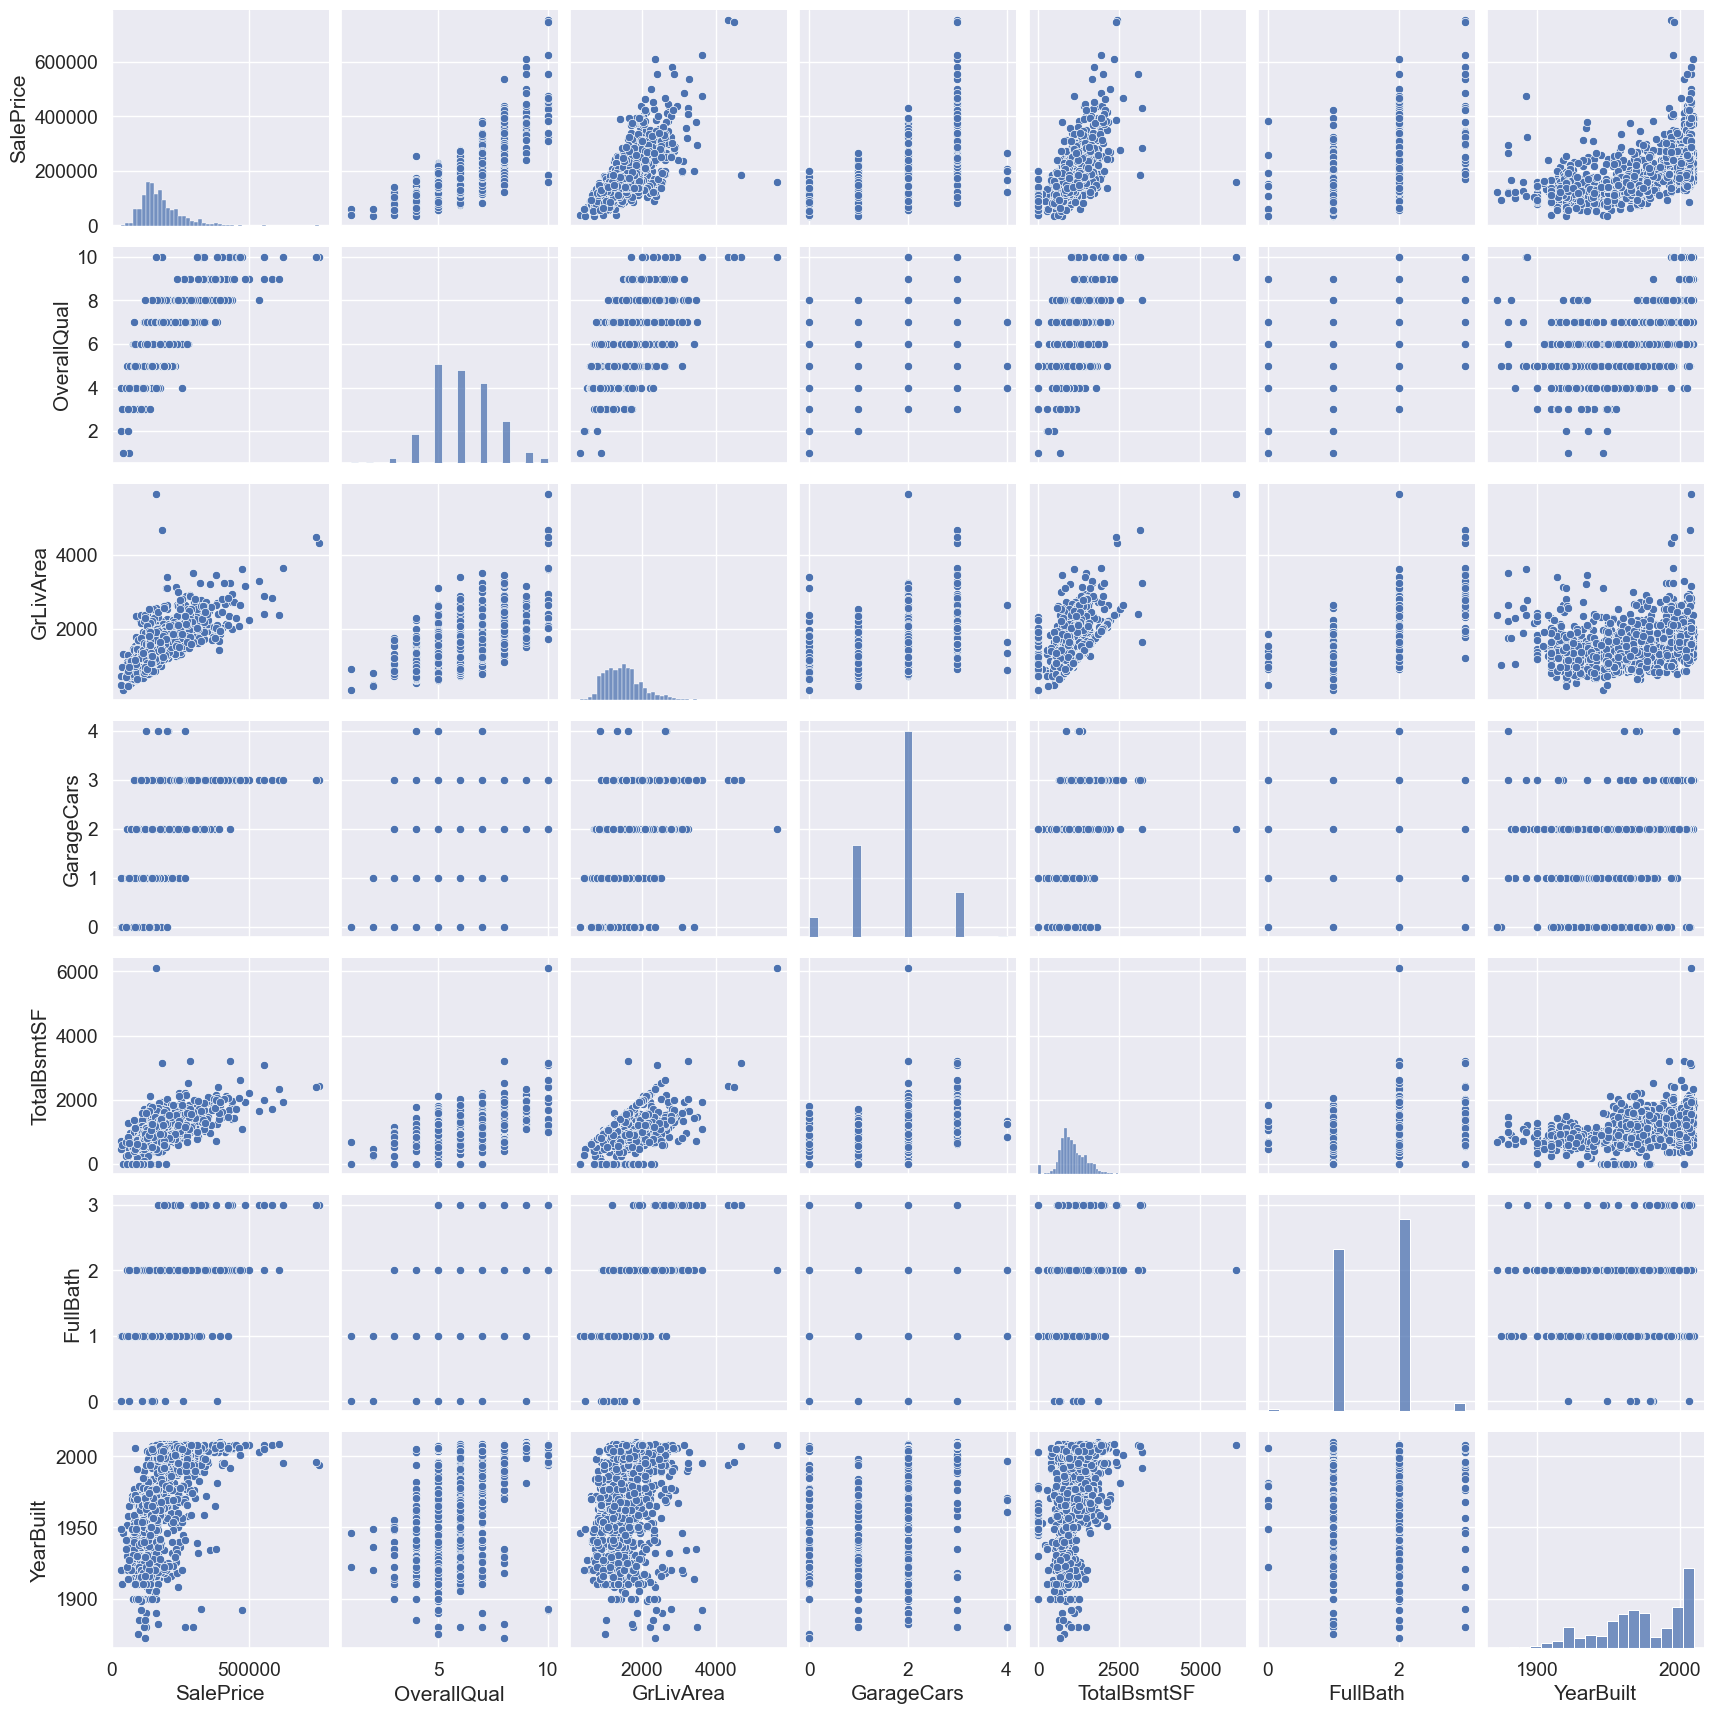

In [17]:
sns.pairplot(train[cols],size=2.5)

<center>Missing data</center>

In [18]:
train=pd.read_csv('train.csv')

In [19]:
total=train.isna().sum().sort_values(ascending=False)
percent=100*(train.isna().sum()/len(train)).sort_values(ascending=False)
missing_data=pd.concat([total,percent],axis=1,keys=['Total','Percent'])
missing_data

,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
...,...,...
ExterQual,0,0.000000
Exterior2nd,0,0.000000
Exterior1st,0,0.000000
RoofMatl,0,0.000000


&emsp;&emsp;当超过15%的数据丢失时，我们应该删除相应的变量并假装它不存在；为了处理丢失的数据，我们将删除除变量Electrical之外的所有丢失数据的变量。在Electrical中，我们将删除缺少数据的观察结果。

In [20]:
train.drop(missing_data[missing_data['Total']>1].index,axis=1,inplace=True)
train.drop(train.loc[train['Electrical'].isna(),:].index,axis=0,inplace=True)
train.isna().sum().sum()

0

<center>单变量分析</center>

In [21]:
# 标准化处理
from sklearn.preprocessing import StandardScaler
transform = StandardScaler()
# 我们这里需要将SalePrice变成一个二维数组
saleprice_scaled = transform.fit_transform(train[['SalePrice']])
# 排序之后，将前10个和后十个都筛选出来
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]

In [22]:
print(low_range)
print('')
print(high_range)

[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


<center>双变量分析</center>

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

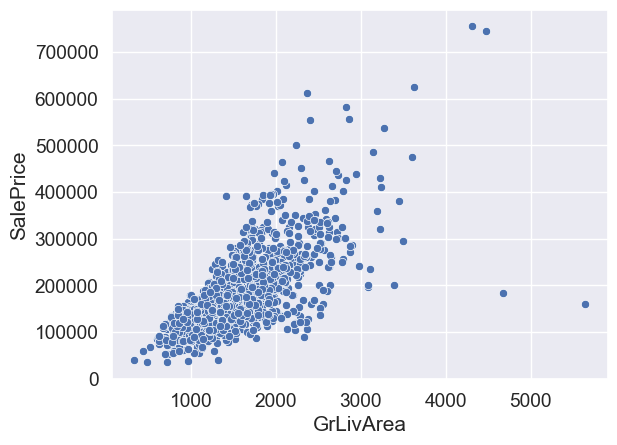

In [23]:
var='GrLivArea'
data=pd.concat([train['SalePrice'],train[var]],axis=1)
sns.scatterplot(data=data,x=var,y='SalePrice')

&emsp;&emsp;从图中可以看出，GrLivArea较大的两个值比较奇怪，我们可以推测一下可能是因为该地区为农业用地，所以SalePrice较低，我们可以考虑删除这两个；头顶上还有2个点，这个就是我们刚刚标准化之后得到的点，值得研究一番

In [24]:
# 找出GrLivArea中前2个点将其删除
GrLivArea_index=train.sort_values('GrLivArea',ascending=False)[:2].index
train.drop(GrLivArea_index,axis=0,inplace=True)

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

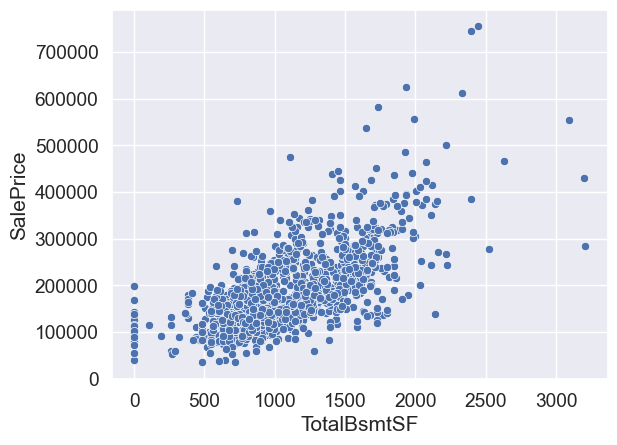

In [25]:
var='TotalBsmtSF'
data=pd.concat([train['SalePrice'],train[var]],axis=1)
sns.scatterplot(data=data,x=var,y='SalePrice')

<center>寻找常态</center>

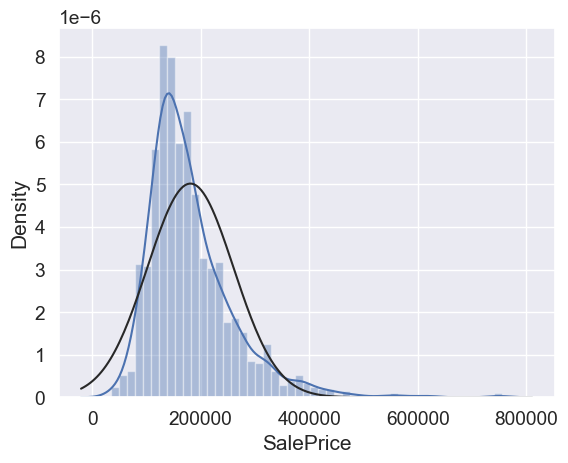

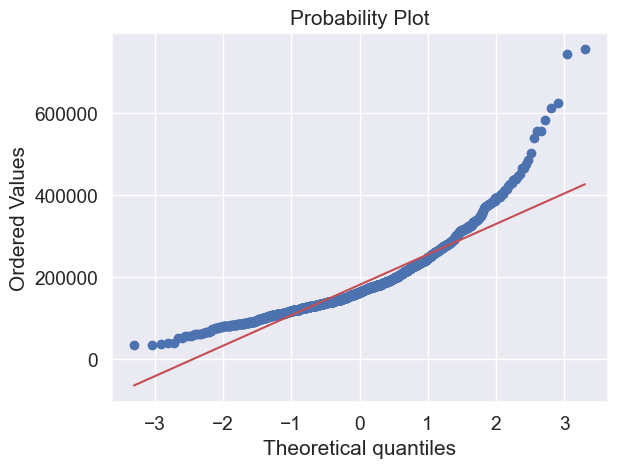

In [26]:
# 注意这个是distplot
sns.distplot(train.SalePrice,fit=norm)
fig=plt.figure()
# 绘制QQ图，目的是比较数据的分布和理论上的正态分布。
# 如果数据点大致沿着参考线排列，这表明数据接近正态分布
res=stats.probplot(train.SalePrice,plot=plt)

&emsp;&emsp;统计学书上写过，我们可以采取对数转化的方式来解决这个问题

In [27]:
train.SalePrice=np.log(train.SalePrice)

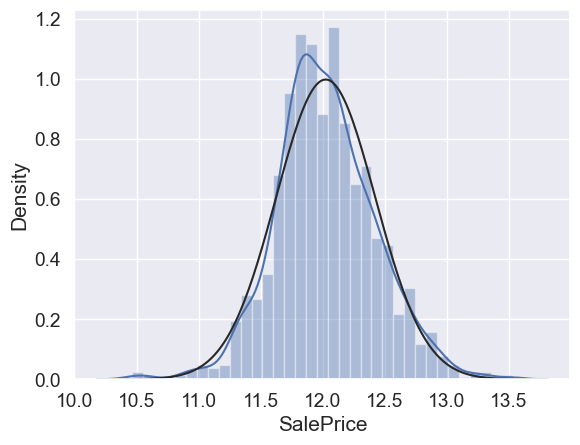

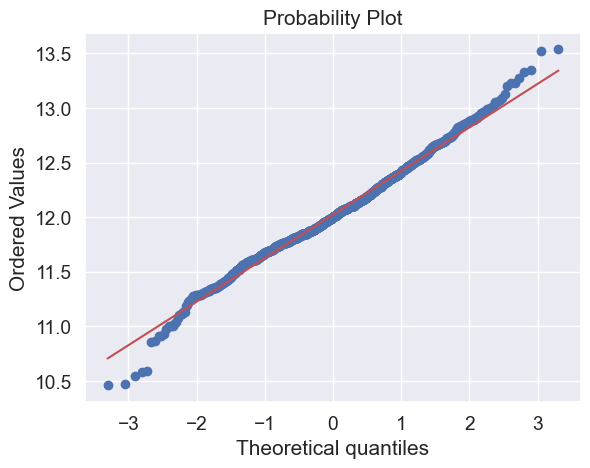

In [28]:
sns.distplot(train.SalePrice,fit=norm)
fig=plt.figure()
# 绘制QQ图，目的是比较数据的分布和理论上的正态分布。
# 如果数据点大致沿着参考线排列，这表明数据接近正态分布
res=stats.probplot(train.SalePrice,plot=plt)

&emsp;&emsp;可以看出，经过对数变化之后，SalePrice符合正态分布的规律

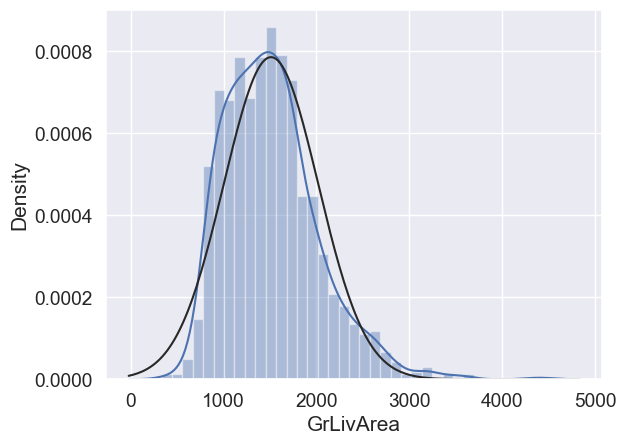

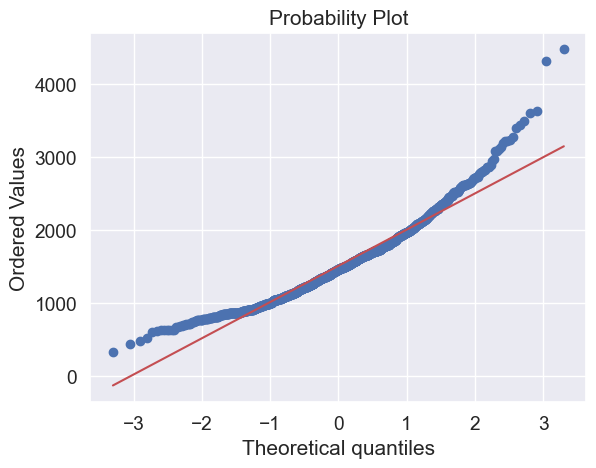

In [29]:
sns.distplot(train['GrLivArea'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

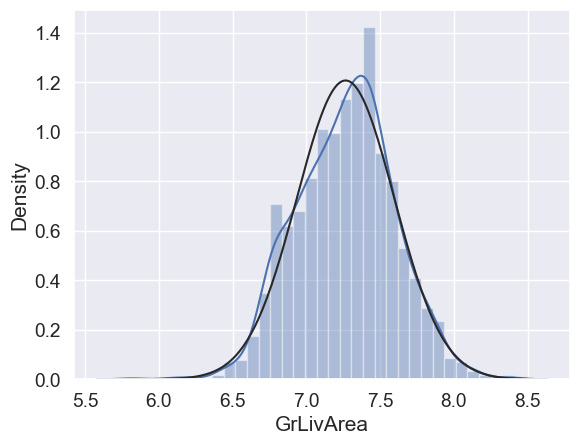

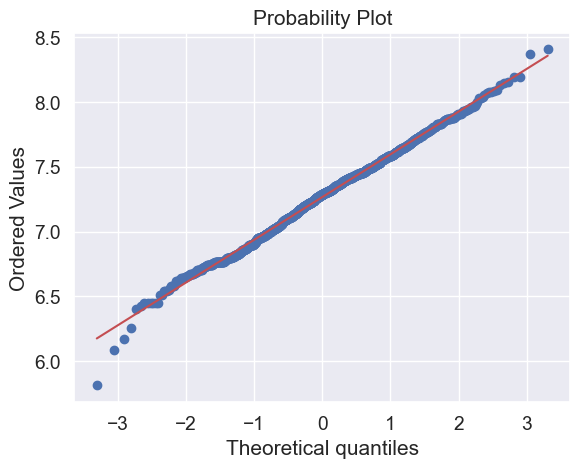

In [30]:
train['GrLivArea'] = np.log(train['GrLivArea'])
sns.distplot(train['GrLivArea'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

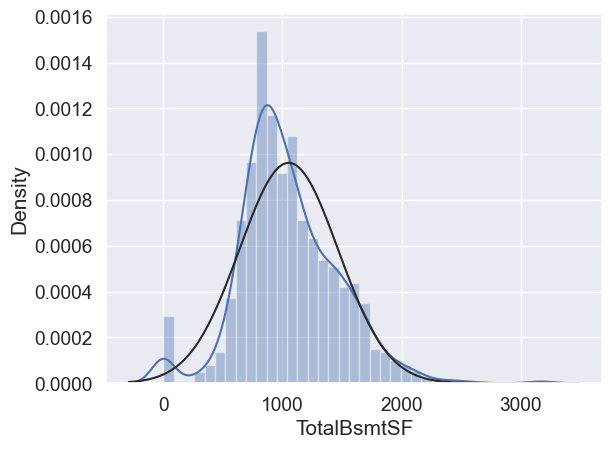

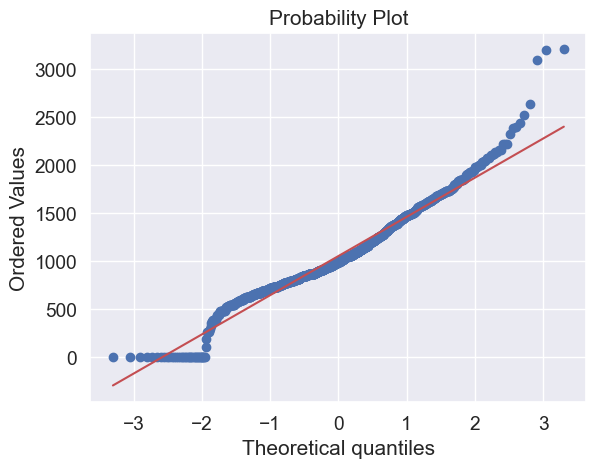

In [31]:
sns.distplot(train['TotalBsmtSF'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['TotalBsmtSF'], plot=plt)

&emsp;&emsp;为了在此处应用对数转换，我们将创建一个变量，该变量可以获得有或没有地下室（二进制变量）的效果。然后，我们将对所有非零观测值进行对数变换，忽略那些值为零的观测值。这样我们就可以转换数据，而不会失去有或没有地下室的效果。

In [32]:
train.isna().sum().sort_values(ascending=False)

Id              0
Fireplaces      0
1stFlrSF        0
2ndFlrSF        0
LowQualFinSF    0
               ..
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
SalePrice       0
Length: 63, dtype: int64

In [33]:
train['HasBsmt']=np.nan
train.loc[:,'HasBsmt']=(train.TotalBsmtSF>0).astype(int)
# HasBsmt_index=(train.HasBsmt==0).index
# train.drop(HasBsmt_index,axis=0,inplace=True)

In [34]:
train.loc[train['HasBsmt']==1,'TotalBsmtSF']=np.log(train.loc[train['HasBsmt']==1,'TotalBsmtSF'])

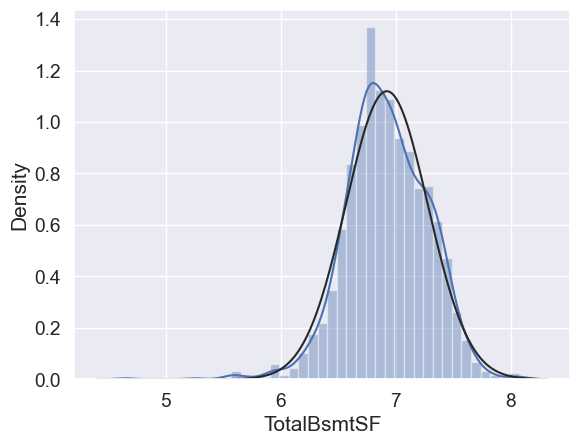

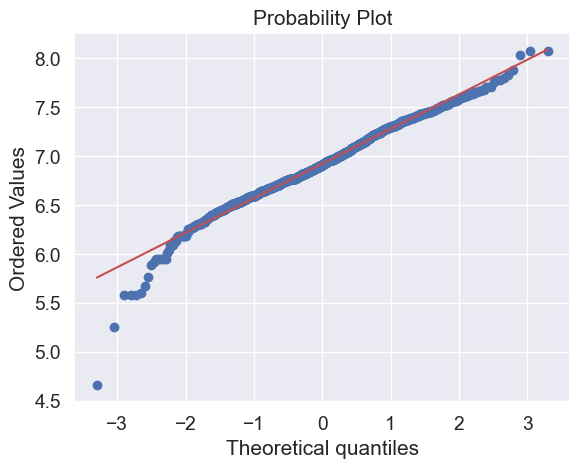

In [37]:
sns.distplot(train.loc[train['HasBsmt']==1,'TotalBsmtSF'],fit=norm)
fig=plt.figure()
res=stats.probplot(train.loc[train['HasBsmt']==1,'TotalBsmtSF'],plot=plt)

&emsp;&emsp;在不破坏原有train的基础之上，我们筛选出了那些TotalBsmtSF大于0的个体，并将其对数化，最终解决了非正态分布问题

<center>同方差性检验</center>

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

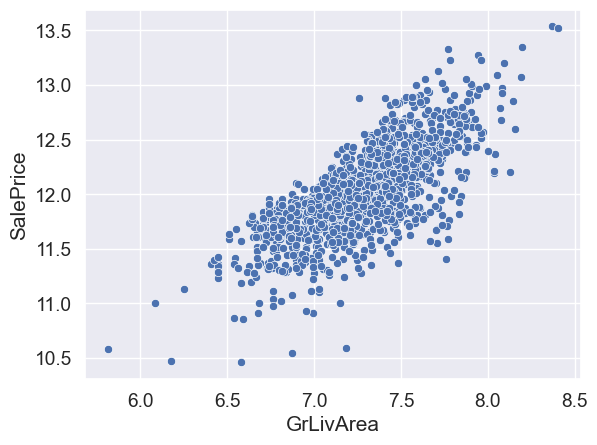

In [38]:
# GrLivArea
sns.scatterplot(data=train,x='GrLivArea',y='SalePrice')

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

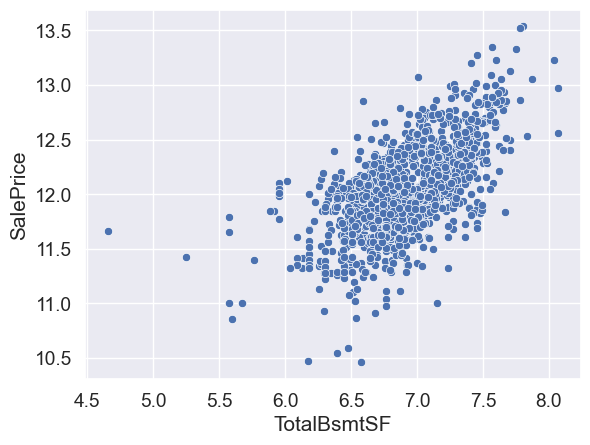

In [39]:
# TotalBsmtSF
sns.scatterplot(x=train.loc[train.HasBsmt==1,'TotalBsmtSF'],y=train.loc[train.HasBsmt==1,'SalePrice'])